# EQ. 10.3 does not converge.
## HAH!
### (Except actually it does.)

To determine whether the Equation 10.3. in Stephen Marsland's book *Machine Learning: An Algorithmic Perspective* would lead the probabilistic evolutionary model to converge, Gavin implemented a genetic algorithm in this notebook that generates populations from a string of probabilities.

$$ p = p \times (1 - \eta) + \frac{\eta(\text{best} + \text{second})}{2} $$

After a lengthy, arduous back-and-forth, he discovered that the equation, as stated in the book, does, indeed, contrary to his expectations&mdash;converge.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

First we initialise a string of probabilities that represents the optimal gene selection (corresponding to a measure on some task; it is only for the sake of having some optimum).

Then we initialise the string of probabilities on which we begin to learn, along with some other parameters about our population.

In [2]:
true_probability = np.array([1.0, 0.0, 1.0, 0.0, 1.0])
predict_probability = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
max_epoch = 10000
population_size = 3
lr = 0.005
predict_probability_list = np.empty((max_epoch, predict_probability.shape[0]))
error = np.empty(max_epoch)

At each epoch we generate a pool of new individuals from `predict_probability`.

We measure their fitness by comparing their genes to the optimum values (`true_probability`).

We rank the individual according to its fitness.

In [3]:
for epoch in range(max_epoch):
    fst_fit = 1000000
    fst_person = []
    snd_fit = 1000000
    snd_person = []
    
    # Generate and rank individuals.
    for i in range(population_size):
        # Generate an individual.
        person = np.random.rand(predict_probability.shape[0])
        for j in range(predict_probability.shape[0]):
            person[j] = 0.0 if person[j] > predict_probability[j] else 1.0
        
        # Rank its fitness.
        fitness = np.sum(np.abs(true_probability - person))
        if fitness < fst_fit:
            snd_fit = fst_fit
            snd_person = fst_person
            fst_fit = fitness
            fst_person = person
        elif fitness < snd_fit:
            snd_fit = fitness
            snd_person = person
    
    # Adjust the probabilities of each gene.
    predict_probability = predict_probability * (1 - lr) + lr*(fst_person+snd_person)/2
    predict_probability_list[epoch] = predict_probability
    
    # Calculate the error for this epoch.
    error[epoch] = np.sum(np.abs(true_probability - predict_probability))

Here we compare the change in probabilities `predict_probability` over the epochs.

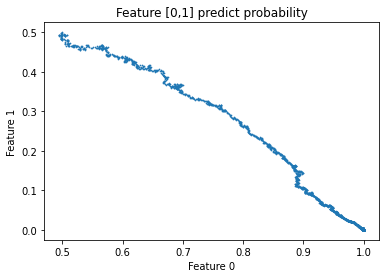

In [4]:
plt.scatter(predict_probability_list[:,0],predict_probability_list[:,1], s=0.5)
plt.title('Feature [0,1] predict probability')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

Here we visualise the error over the epochs.

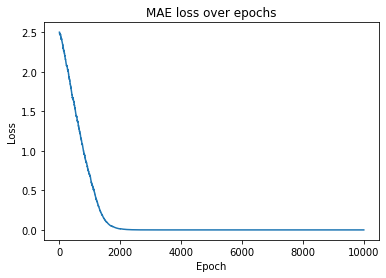

In [5]:
plt.title('Overall SAE')
plt.title('MAE loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(error)

Q.E.D. we can see that the error diminishes as the algorithm progresses, even though the learning-rate stays constant, therefore it converges.

### Dr. Joss Whittle's Witty Rebuttal

The no-free-lunch theorem applies to the general case and for fitness spaces with unknown curvature and discontinuities.

The mean-absolute-error loss-space is smooth in all dimensions sloping directly towards a single global optimum, so convergence is guaranteed in the limit for sensibly chosen learning-rates.

If you add a constraint to the loss function which introduces local optima and sharp edges, such as&mdash;

```
# Local minima
red_herring_probability = np.array([1.0, 1.0, 0.0, 1.0, 0.0])
red_herring_mae = max(np.sum(np.abs(red_herring_probability - person)), 0.5)

# Global minima
true_mae = np.sum(np.abs(true_probability - person))

# Constraint that adds some cliff edges
constraint = (1 if np.sum(person) == np.sum(true_probability) else np.inf)

fitness = min(true_mae, red_herring_mae) * constraint
```

&mdash;which has the same global optimum, then the algorithm is not guaranteed to converge, especially when the size of the genome is increased from 5 to something like 100.

In real-world problems for GA you don't have `true_probability` to make a direct comparison to: you have some task or objective function defined `fitness(person)`, which can have much more interesting properties (and disjoint regions).

#### Implementing Joss' Objections

In [6]:
population_size = 100
genome_size = 100
true_probability = np.random.randint(0, 1, size=genome_size).astype(float)
predict_probability = np.array([0.5] * genome_size)
predict_probability_list = np.empty((max_epoch, predict_probability.shape[0]))
error = np.empty(max_epoch)

In [7]:
for epoch in range(max_epoch):
    fst_fit = 1000000
    fst_person = []
    snd_fit = 1000000
    snd_person = []
    
    # Generate and rank individuals.
    for i in range(population_size):
        # Generate an individual.
        person = np.random.rand(predict_probability.shape[0])
        for j in range(predict_probability.shape[0]):
            person[j] = 0.0 if person[j] > predict_probability[j] else 1.0
        
        # Rank its fitness.
        fitness = np.sum(np.abs(true_probability - person))
        if fitness < fst_fit:
            snd_fit = fst_fit
            snd_person = fst_person
            fst_fit = fitness
            fst_person = person
        elif fitness < snd_fit:
            snd_fit = fitness
            snd_person = person
    
    # Adjust the probabilities of each gene.
    predict_probability = predict_probability * (1 - lr) + lr*(fst_person+snd_person)/2
    predict_probability_list[epoch] = predict_probability
    
    # Constraint that adds some cliff edges
    constraint = (1 if np.sum(person) == np.sum(true_probability) else np.inf)
    
    # Calculate the error for this epoch.
    true_mae = np.sum(np.abs(true_probability - predict_probability))
    red_herring_mae = true_mae * constraint
    
    fitness = min(true_mae, red_herring_mae) * constraint
    
    error[epoch] = fitness

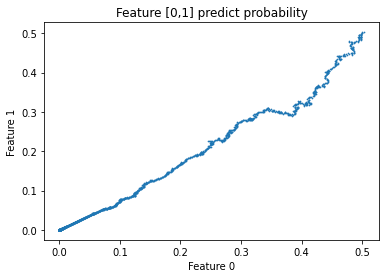

In [8]:
plt.scatter(predict_probability_list[:,0],predict_probability_list[:,1], s=0.5)
plt.title('Feature [0,1] predict probability')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

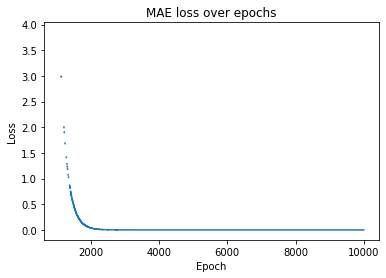

In [9]:
plt.title('Overall SAE')
plt.title('MAE loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(error)